In [2]:
from scipy.constants import c
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm

In [2]:
clusters = fits.getdata("dr8_run_redmapper_v5.10_lgt20_catalog.fit")

In [3]:
#cutting clusters that don't have redshift
cluster_z_filter = clusters["BCG_SPEC_Z"]
clusters = clusters[np.where(cluster_z_filter != -1)]
print("Length of clusters after cutting those without redshift:", len(clusters))

Length of clusters after cutting those without redshift: 16656


In [4]:
dr14 = fits.getdata("specObj-dr14.fits")
#cutting dr14 on class
clss = dr14["CLASS"]
dr14 = dr14[np.where(clss == "GALAXY")]
print("Length of dr14 after cutting on class:", len(dr14))
#cutting data with suspicious redshifts
dr14 = dr14[np.where((dr14['ZWARNING']==16) |
                   (dr14['ZWARNING']==0) |
                   (dr14['ZWARNING']==4))]
print("Length of dr14 after cutting out suspicious redshifts:", len(dr14))
np.save("cut_clusters2.npy", clusters)
np.save("cut_dr142.npy", dr14)

Length of dr14 after cutting on class: 2779151
Length of dr14 after cutting out suspicious redshifts: 2635685


In [5]:
dt=clusters[1:5]
df=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)
pd.set_option('display.max_columns', 500)
df.head()

,MEM_MATCH_ID,RA,DEC,MODEL_MAG,MODEL_MAGERR,IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA,C_LAMBDA_ERR,MAG_LAMBDA_ERR,CHISQ,Z_LAMBDA,Z_LAMBDA_E,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS,PZ,NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT,DEC_CENT,ID_CENT,LAMBDA_CHISQ_CENT,ZLAMBDA_CENT,P_BCG,P_CEN,Q_CEN,P_FG,Q_MISS,P_SAT,P_C,BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
0,4,230.600092,27.714369,"[17.745682, 15.765336, 14.839079, 14.427721, 1...","[0.024927424, 0.0032128638, 0.0025435446, 0.00...",14.448995,0.002525,0.076568,0.011801,3.239213,0.069041,-1.000000,0.051038,0.080261,133.515747,4.397382,130.678329,3.920125,1.059514,1.046523,0.046024,"[1.8691438, 0.87587416, 0.39345893, 0.31646612]","[0.0024012516, 6.466713e-05, 4.4463868e-05, 0....","[0.0023605237, 4.0946295e-05, 2.2213657e-05, 2...",2.258066,0.079783,0.007193,0.015627,45120301202090548,360.167908,-3.511638,356.656281,"[0.03921186, 0.043268934, 0.047326013, 0.05138...","[9.779953e-06, 0.00020469692, 0.002381726, 0.0...",1,1.589270,230.621564,27.707631,1.393579,4.253886,141.704514,196.791122,8643.178711,133.969025,0.748697,5,4,"[230.60009187643863, 230.62156355660142, 230.6...","[27.714369052606486, 27.707631468188342, 27.67...","[28885825, 28886055, 28886128, 28886049, 28885...","[133.51575, 134.87344, 132.69199, 133.79034, 1...","[0.08003884, 0.07969745, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.54657, 0.37469944, 0.057146966, 0.016078142...","[0.24606082, 0.16868626, 0.025727041, 0.007238...","[9.386968e-05, 0.0045184894, 0.00039432713, 0....",-1.322825,"[0.45333612, 0.620782, 0.9424587, 0.9828617, 0...","[0.30917212, 0.23477708, 0.044700995, 0.012993...",3.392455,87.916885,0.080039,0.001728,175.399353,21.140350,21.0
1,6,203.833723,41.001146,"[19.995804, 17.901672, 16.366825, 15.850655, 1...","[0.107984856, 0.009154892, 0.0045009954, 0.004...",15.923666,0.004324,0.258183,0.010269,5.782617,0.228309,0.228309,0.258183,0.236098,190.996490,5.667876,175.711014,5.209084,1.138165,1.007606,0.010407,"[1.87869, 1.3443203, 0.4924913, 0.33730394]","[0.12091971, 0.0012286201, 0.00045845855, 0.00...","[0.11959795, 0.00097178435, 0.00023139443, 0.0...",11.636747,0.231596,0.005989,0.015653,39190301400210138,322.990448,2.318103,325.308563,"[0.19635104, 0.19987558, 0.2034001, 0.20692465...","[8.6275793e-07, 2.8410159e-05, 0.0008116087, 0...",1,1.707247,203.833723,41.001146,1.171649,5.743537,88.327370,341.513123,8660.248047,190.996490,0.000000,5,1,"[203.83372267931975, 203.81826148910173, 203.7...","[41.0011464409052, 41.013149364143544, 40.9775...","[23718404, 23718515, 23718433, 23718443, 23718...","[190.99649, 0.0, 0.0, 0.0, 0.0]","[0.23023634, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.9996656, 0.0003289845, 4.359725e-06, 7.1390...","[0.97640026, 0.000321328, 4.258261e-06, 6.9729...","[3.3679346e-05, 0.0016452592, 0.009282246, 0.0...",-7.500886,"[0.00030070273, 0.9980258, 0.9907134, 0.934557...","[0.9767193, 0.01361882, 0.0001829359, 2.996047...",8.065262,131.307648,0.230236,0.001983,276.459167,21.120052,21.0
2,8,150.558906,20.537949,"[21.571142, 19.440008, 17.76432, 17.182882, 16...","[0.4019186, 0.027899064, 0.010375315, 0.009191...",17.218683,0.009204,0.307712,0.016845,1.670911,0.319619,0.320468,0.294900,0.317472,153.392975,5.798571,116.826805,5.647635,1.089334,0.991426,0.000000,"[1.7378201, 1.5410571, 0.5642925, 0.3710528]","[0.4319495, 0.0051411786, 0.0011786495, 0.0033...","[0.42127, 0.004448875, 0.0006520851, 0.0005207...",0.935555,0.324495,0.012751,0.032738,51380301200690289,310.611298,-1.126765,309.484528,"[0.2455487, 0.25344333, 0.261338, 0.26923263, ...","[4.78119e-09, 4.886734e-07, 2.7867156e-05, 0.0...",1,1.634001,150.611819,20.517165,1.124652,8.069870,327.751801,197.223557,25316.328125,154.564667,6.776568,5,

In [6]:
central_ra = np.radians(clusters["RA"])
central_dec = np.radians(clusters["DEC"])
member_ra = np.radians(dr14["PLUG_RA"])
member_dec = np.radians(dr14["PLUG_DEC"])

In [7]:
r_lambda = clusters["R_LAMBDA"]
central_z = clusters["BCG_SPEC_Z"]
member_z = dr14["Z"]
richness = clusters["LAMBDA_CHISQ"]

In [8]:
COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(central_z).value #Mpc

In [9]:
theta_max = 5 * r_lambda / angular_diameter_distances #radians
vmax = 3e6 * (richness / 20.0) ** 0.45  # m/s

In [10]:
myra = (dr14["PLUG_RA"] * u.deg).to(u.rad).value
mydec = (dr14["PLUG_DEC"] * u.deg).to(u.rad).value

In [11]:
def matchingroutine (RAnew, DECnew, RAorig, DECorig):

    new_ra = Angle(RAnew, unit=u.degree)
    new_dec = Angle(DECnew, unit=u.degree)
    red_coord = SkyCoord(ra=new_ra, dec=new_dec, unit = (u.deg, u.deg))

    orig_ra = Angle(RAorig, unit=u.degree)
    orig_dec = Angle(DECorig, unit=u.degree)
    sdss_coord = SkyCoord(ra=orig_ra, dec=orig_dec, unit = (u.deg, u.deg))

    idx, d2d, d3d = red_coord.match_to_catalog_sky(sdss_coord)

    #print ("idx is %s long" % (len(idx)))
    #print("idx refers to indices in the second catalog that items in the first match")
    return idx, d2d

In [12]:
dr14_ra = dr14["PLUG_RA"]
dr14_dec = dr14["PLUG_DEC"]
members=clusters
member_ra = members["RA"]
member_dec = members["DEC"]

#Matches first to second: what index of dr14 does members[i] correspond to?
idx, d2d = matchingroutine(member_ra, member_dec, dr14_ra, dr14_dec)
print("Length of member matching data:", len(idx))

good_matches = np.where(d2d <= 2*u.arcsec)[0]
print("Length of matching data after cutting bad distance matches:", len(good_matches))
members = members[good_matches]
idx = idx[good_matches]
mydr14 = dr14[idx]

member_z = members["BCG_SPEC_Z"]
dr14_z = mydr14["Z"]

good_matches = np.where(np.abs(member_z - dr14_z) < 0.03)[0]

print("Length of matching data after cutting differing z values:", len(good_matches))

members = members[good_matches]
mydr14 = mydr14[good_matches]

Length of member matching data: 16656
Length of matching data after cutting bad distance matches: 16610
Length of matching data after cutting differing z values: 16605


In [13]:
clusters=members
central_ra = np.radians(clusters["RA"])
central_dec = np.radians(clusters["DEC"])
member_ra = np.radians(dr14["PLUG_RA"])
member_dec = np.radians(dr14["PLUG_DEC"])
richness = clusters["LAMBDA_CHISQ"]
r_lambda = clusters["R_LAMBDA"]
r_lambda = ((richness / 100)**0.2) #Mpc
central_z = clusters["BCG_SPEC_Z"]
member_z = dr14["Z"]
COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(central_z).value #Mpc
theta_max = 5 * r_lambda / angular_diameter_distances #radians
vmax = 3e6 * (richness / 20.0) ** 0.45  # m/s

In [14]:
myra = (dr14["PLUG_RA"] * u.deg).to(u.rad).value
mydec = (dr14["PLUG_DEC"] * u.deg).to(u.rad).value

In [15]:
#Be careful! If you don't re-initialize them the lists will just 
#keep growing

mem_idx = np.empty(len(clusters), dtype=object)
clust_idx = np.empty(len(clusters), dtype=object)
r = np.empty(len(clusters), dtype=object)
x = np.empty(len(clusters), dtype=object)
v = np.empty(len(clusters), dtype=object)
sep2d = np.empty(len(clusters), dtype=object)
rich = np.empty(len(clusters), dtype=object)
zcen = np.empty(len(clusters), dtype=object)

for i in range(len(clusters)):
    mem_idx[i]=[]
    r[i]=[]
    x[i]=[]
    v[i]=[]
    sep2d[i]=[]

    
for i in tqdm(range(len(clusters))):
    sep=np.arccos(np.sin(member_dec)*math.sin(central_dec[i])+np.cos(member_dec)*math.cos(central_dec[i])*np.cos(member_ra-central_ra[i]))
    """
    ra1=member_ra*360/2/math.pi
    dec1=member_dec*360/2/math.pi
    ra2=central_ra[i]*360/2/math.pi
    dec2=central_dec[i]*360/2/math.pi
    
    ra_1 = Angle(ra1, unit=u.degree)
    dec_1 = Angle(dec1, unit=u.degree)
    coord1 = SkyCoord(ra=ra_1, dec=dec_1, unit = (u.deg, u.deg))

    ra_2 = Angle(ra2, unit=u.degree)
    dec_2 = Angle(dec2, unit=u.degree)
    coord2 = SkyCoord(ra=ra_2, dec=dec_2, unit = (u.deg, u.deg))

    sep2 = coord1.separation(coord2)
    """
    vel=c * (member_z - central_z[i]) / (1 + central_z[i])

    this_ra = central_ra[i]
    this_dec = central_dec[i]
    this_tmax = theta_max[i]

    delta_ra = np.abs(this_ra - myra)
    delta_dec = np.abs(np.sin(this_dec) - np.sin(mydec))
#Note: below is the condition that matches Paxton's count; the difference in theta cuts is 
#that he does it in two steps
#Angular distance = distance between two points on a sphere
#This is not the same as alpha_2-alpha_1
#    idx=np.where( (delta_ra < this_tmax) & (delta_dec < this_tmax) )[0]
#    idx=np.where( (delta_ra < this_tmax) & (delta_dec < this_tmax) & (sep<=theta_max[i]))[0]
    idx=np.where( (delta_ra < this_tmax) & (delta_dec < this_tmax) & (sep<=theta_max[i]) & (np.abs(vel)<=vmax[i]) )[0]
#    idx=np.where( (sep<theta_max[i]) & (np.abs(vel)<vmax[i]) )[0]
    #idx=np.where( (sep<=theta_max[i]) )[0]
    clust_idx[i]=clusters["MEM_MATCH_ID"][i]
    rich[i]=richness[i]
    zcen[i]=central_z[i]
    
    mem_idx[i].extend(idx.tolist())
    r[i].extend( (sep[idx]*angular_diameter_distances[i]).tolist() )
    x[i].extend( (sep[idx]*angular_diameter_distances[i]/r_lambda[i]).tolist() )
    v[i].extend( (vel[idx]).tolist() )
    sep2d[i].extend( sep[idx].tolist() )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less_equal


In [16]:
matched_df=pd.DataFrame({'clust_idx':clust_idx,'rich':rich,'zcen':zcen,'mem_idx':mem_idx,'r':r,'x':x,'v':v,'sep2d':sep2d})

In [17]:
population = np.empty(len(matched_df), dtype=object)
full_stack_sep=[]
full_stack_r=[]

for i in range(len(matched_df)):
    full_stack_sep.extend( matched_df['sep2d'][i] )
    full_stack_r.extend( matched_df['x'][i] )
    population[i]=len(matched_df['x'][i])
len(full_stack_r)

275449

16605

In [62]:
pax_theta_max=np.load("pax_theta_max.npy")
theta_max=np.unique(theta_max[0:500])

In [63]:
pax_theta_max=np.unique(pax_theta_max)

In [66]:
theta_max-pax_theta_max

array([ 0.0000000e+00, -4.6566129e-10,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        9.3132257e-10,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

In [18]:
matched_df.to_pickle("matchedroutine_matches_circle.pkl")

In [3]:
matched_df=pd.read_pickle("matchedroutine_matches_circle.pkl")

In [4]:
matched_df

,clust_idx,rich,zcen,mem_idx,r,x,v,sep2d
0,1,180.104,0.0908067,"[501747, 502229, 502230, 502232, 502233, 50223...","[5.6110908674608515, 2.4302224365217415, 1.920...","[4.988183393406467, 2.1604346617233126, 1.7075...","[678631.25, 1039578.625, 3342158.5, -1664093.6...","[0.022960429390492056, 0.009944403321024335, 0..."
1,4,133.516,0.069041,"[593826, 593833, 593838, 593897, 593899, 59390...","[5.04345415660707, 5.164319493020324, 5.177900...","[4.760160043959741, 4.8742362955184895, 4.8870...","[4242948.5, 2543158.25, 4066316.75, 1308404.37...","[0.026466021057445246, 0.027100273781729026, 0..."
2,6,190.996,0.228309,"[534677, 534681, 534683, 534686, 534703, 53470...","[0.061083815869358016, 0.5678801592298298, 3.9...","[0.05366869936992902, 0.49894377275048046, 3.4...","[3201788.25, 289691.28125, -7214729.0, 1223462...","[0.00011578451562980295, 0.0010764181679943936..."
3,8,153.393,0.319619,"[842147, 842150, 842152, 842180, 842598, 84259...","[5.10529613365609, 2.3724902644042896, 4.42073...","[4.68662092898001, 2.1779270459274542, 4.05820...","[-3779238.75, 4289634.5, -4486142.0, 5261996.5...","[0.0076017237373068305, 0.0035326090959851746,..."
4,11,134.584,0.129045,"[100654, 100655, 100656, 100657, 100658, 10065...","[2.357655524379569, 2.7346903857371374, 2.4495...","[2.2216821689308146, 2.5769722526099583, 2.308...","[-8372.3095703125, -852329.625, -689825.3125, ...","[0.007091467191296127, 0.008225530383159445, 0..."
...,...,...,...,...,...,...,...,...
16600,98070,31.5515,0.50456,"[1296627, 1296629, 1297543, 1297549, 1297583, ...","[2.249816861541191, 3.3789097053329167, 3.5689...","[2.8336302377991935, 4.255715598675728, 4.4950...","[3134704.5, 2818538.0, 3417082.0, 3413899.0, 4...","[0.002540385553323209, 0.0038153031689571446, ..."
16601,99218,26.9292,0.386643,[41282],[0.00043139770258669507],[0.0005608322566252939],[0.0],[5.678105021494003e-07]
16602,102994,36.967,0.473152,"[556591, 1183413, 1183417, 1184203, 1184230, 1...","[0.0013119837558897404, 0.2291039614740473, 0....","[0.00160090509324853, 0.2795565853317174, 1.11...","[0.0, -920208.0, -98730.390625, -428660.53125,...","[1.5338789501737395e-06, 0.0002678522064994147..."
16603,106607,27.4021,0.417066,"[408985, 1990545, 1990937]","[0.0004020047720933392, 2.0560240242045853, 2....","[0.0005208039788112103, 2.663613883888335, 2.6...","[0.0, -102688.4921875, 1325625.375]","[5.053229617420838e-07, 0.0025844373536011394,..."


In [5]:
full_stack_v=[]
population = np.empty(len(matched_df), dtype=object)
full_stack_sep=[]
full_stack_r=[]

for i in range(len(matched_df)):
    full_stack_v.extend( matched_df['v'][i])
    full_stack_sep.extend( matched_df['sep2d'][i] )
    full_stack_r.extend( matched_df['x'][i] )
    population[i]=len(matched_df['v'][i])
len(full_stack_v)

275449

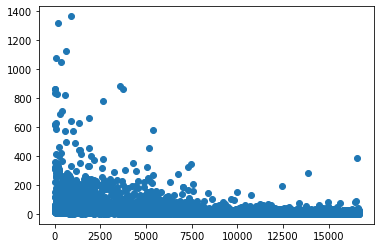

In [5]:
plt.scatter(matched_df['clust_idx'],population);

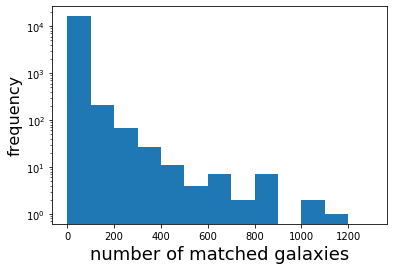

In [6]:
plt.yscale('log')
plt.xlabel('number of matched galaxies', fontsize=18)
plt.ylabel('frequency', fontsize=16)
plt.hist(population,bins=np.arange(0,1400,100));

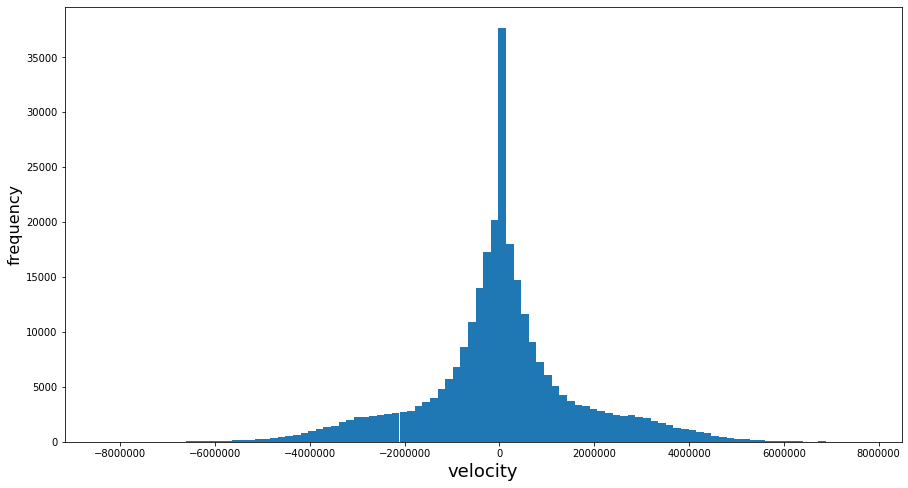

In [7]:
plt.figure(figsize=(15,8))
plt.yscale('linear')
plt.xlabel('velocity', fontsize=18)
plt.ylabel('frequency', fontsize=16)
plt.hist(full_stack_v,bins=100);

In [8]:
from sklearn import mixture

In [9]:
X=np.asarray(full_stack_v).reshape(-1,1)

In [10]:
model=mixture.BayesianGaussianMixture(3,tol=1e-2,max_iter=1000,mean_prior=np.zeros(1)).fit(X)

In [11]:
x = np.linspace(-7000000, 7000000, 1000)

In [12]:
logprob = model.score_samples(x.reshape(-1, 1))
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

In [13]:
model.means_

array([[-1041218.00523995],
       [   -2329.62656821],
       [ 1214463.06836873]])

In [14]:
np.sqrt(model.covariances_)

array([[[1812367.70814097]],

       [[ 379941.2453566 ]],

       [[1796469.02877494]]])

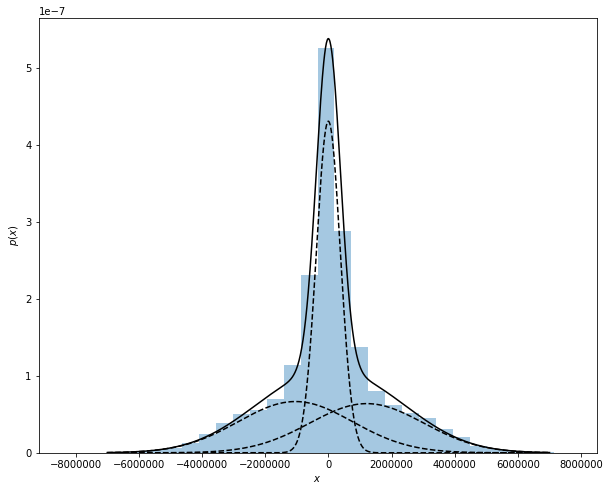

In [25]:
plt.figure(figsize=(10, 8))
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

In [26]:
# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in tqdm(range(len(N))):
    models[i] = mixture.GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

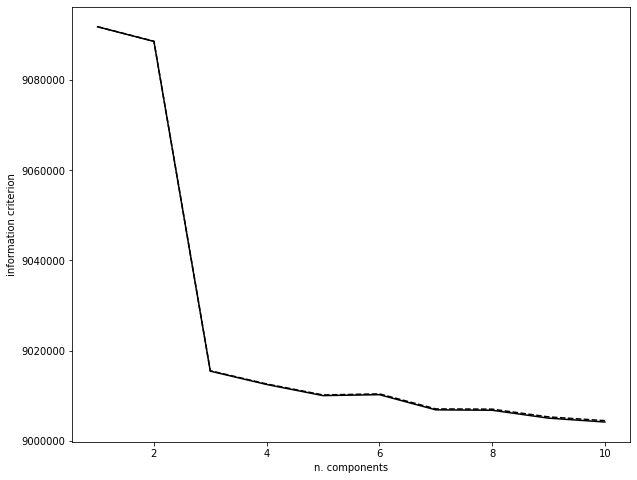

In [27]:
fig=plt.figure(figsize=(10, 8))
ax=fig.add_subplot(1,1,1)
# plot 2: AIC and BIC
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion');

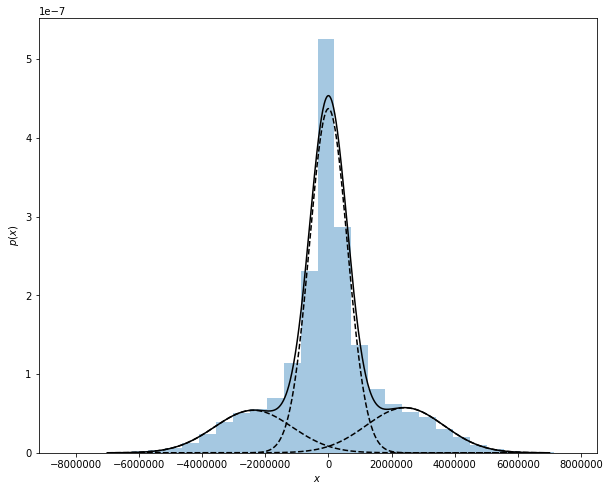

In [28]:
logprob = models[2].score_samples(x.reshape(-1, 1))
responsibilities = models[2].predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

In [29]:
models[2].means_

array([[ 2.42412707e+06],
       [ 6.97648404e+02],
       [-2.37788513e+06]])

In [30]:
np.sqrt(models[2].covariances_)

array([[[1228583.03832071]],

       [[ 599647.07314006]],

       [[1230141.78222956]]])

In [31]:
df=pd.DataFrame({'r':full_stack_r,'v':full_stack_v})

In [32]:
binned=df.loc[ (df.r > 4.5) & (df.r < 5.0) ]

In [33]:
#question: I was expecting to see a rising constant value in addition to the Gaussians

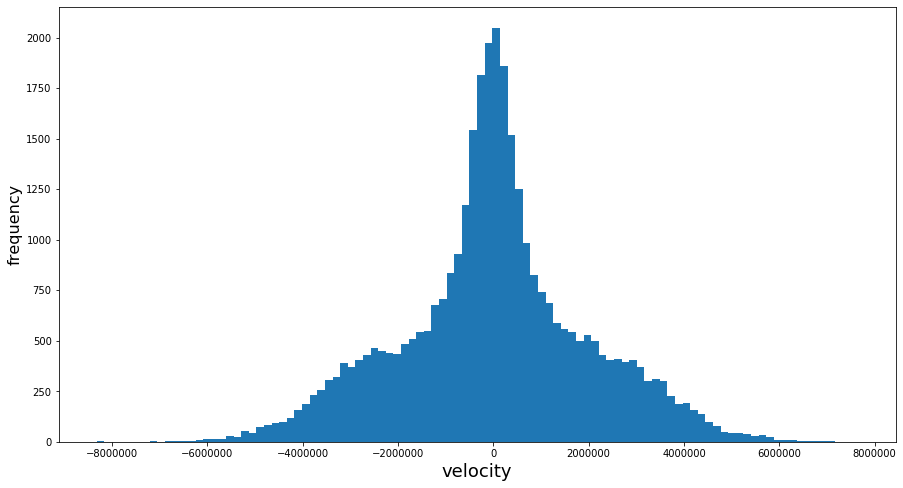

In [34]:
plt.figure(figsize=(15,8))
plt.yscale('linear')
plt.xlabel('velocity', fontsize=18)
plt.ylabel('frequency', fontsize=16)
plt.hist(binned.v,bins=100);

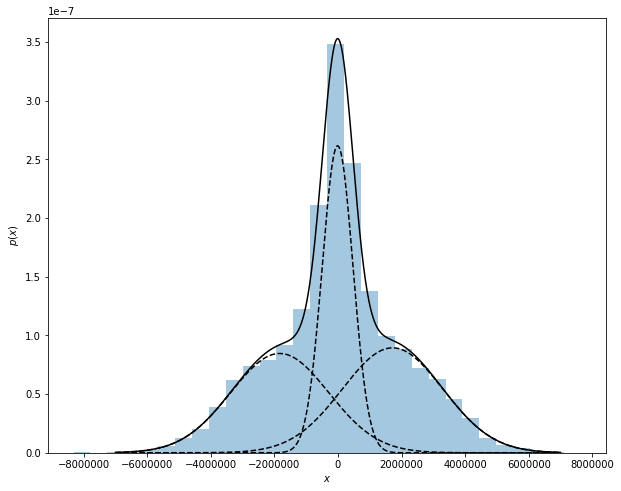

In [35]:
X=np.asarray(binned.v).reshape(-1,1)
model=mixture.BayesianGaussianMixture(3,tol=1e-2,max_iter=1000,mean_prior=np.zeros(1)).fit(X)
x = np.linspace(-7000000, 7000000, 1000)
logprob = model.score_samples(x.reshape(-1, 1))
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

In [ ]:
z_pivot = np.median(zcen)
richness_pivot = np.median(richness)

In [ ]:
def lnlike(theta, velocity, zcen, z_p, richness, lambda_p):
    """
    Defining our log likelihood function. Note that theta will be
    a tuple of four variables, not just one. It represents
    the parameters in our model."""
    p, sigma_p, alpha, beta = theta #unpacking parameters
    
    sigma_v = (sigma_p*((1+zcen)/(1+z_p))**beta*(richness/lambda_p)**alpha)
    gaussian = 1/sigma_v*np.exp(-0.5*(velocity/sigma_v)**2)
    
    two_vmax = 2*calculate_vmax(richness)
    
    lnlike = np.sum(np.log(p*gaussian+(1-p)/two_vmax))
    return lnlike
